In [1]:
%load_ext nb_black
from os.path import join
import numpy as np
import pandas as pd
from typing import Callable

rng_seed = 399
np.random.seed(rng_seed)
import joblib
from tqdm.auto import tqdm
from gudhi import plot_persistence_diagram, bottleneck_distance
from gudhi.wasserstein import wasserstein_distance
from matplotlib import pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.manifold import Isomap
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

import plotly.offline as pyo

pyo.init_notebook_mode()
import plotly.express as px
import plotly.graph_objects as go

# Directory constants
topological_data_analysis_data_dir = "data"
topological_data_analysis_custom_data_dir = "custom_data"
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from utils import (
    get_model_checkpoint_filepaths,
    pairwise_cosine_distances,
    words_to_vectors,
    normalize_array,
)
from word_embeddings.word2vec import load_model_training_output
from vis_utils import plot_word_vectors
from topological_data_analysis.tda_utils import (
    generate_points_in_spheres,
)
from topological_data_analysis.topological_polysemy import tps, tps_point_cloud
from topological_data_analysis.geometric_anomaly_detection import (
    GeometricAnomalyDetection,
)

<IPython.core.display.Javascript object>

# Prepare data

In [2]:
# Constants
tps_neighbourhood_size = 50

<IPython.core.display.Javascript object>

In [3]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
    return_annoy_index=True,
    annoy_index_prefault=True,
)
last_embedding_weights = w2v_training_output["last_embedding_weights"]
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
last_embedding_weights_annoy_index = w2v_training_output[
    "last_embedding_weights_annoy_index"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

In [4]:
# Load SemEval data
semeval_2010_14_word_senses = joblib.load(
    join(topological_data_analysis_data_dir, "semeval_2010_14_word_senses.joblib")
)

<IPython.core.display.Javascript object>

In [5]:
# Only use SemEval words in vocabulary
semeval_target_word_tps_scores = {}
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_gs_clusters_in_vocab)

<IPython.core.display.Javascript object>

# Compute TPS/persistence diagrams

In [6]:
tps_pds = []
tps_scores = []
for word, senses in tqdm(
    zip(semeval_target_words_in_vocab, semeval_gs_clusters_in_vocab),
    total=num_semeval_words,
):
    tps_score, tps_pd = tps(
        target_word=word,
        word_to_int=word_to_int,
        neighbourhood_size=tps_neighbourhood_size,
        word_embeddings_normalized=last_embedding_weights_normalized,
        annoy_index=last_embedding_weights_annoy_index,
        return_persistence_diagram=True,
    )
    tps_scores.append(tps_score)
    tps_pds.append(tps_pd)
tps_scores = np.array(tps_scores)
tps_pds = np.array(tps_pds, dtype=object)

  0%|          | 0/98 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [7]:
tps_scores_sorted_indices = np.argsort(tps_scores)[::-1]
tps_scores_sorted = tps_scores[tps_scores_sorted_indices]
tps_pds_sorted = tps_pds[tps_scores_sorted_indices]
semeval_target_words_in_vocab_sorted = semeval_target_words_in_vocab[
    tps_scores_sorted_indices
]
semeval_gs_clusters_in_vocab_sorted = semeval_gs_clusters_in_vocab[
    tps_scores_sorted_indices
]

<IPython.core.display.Javascript object>

# Visulize PDs with high/low TPS_50 scores

usetex mode requires dvipng.


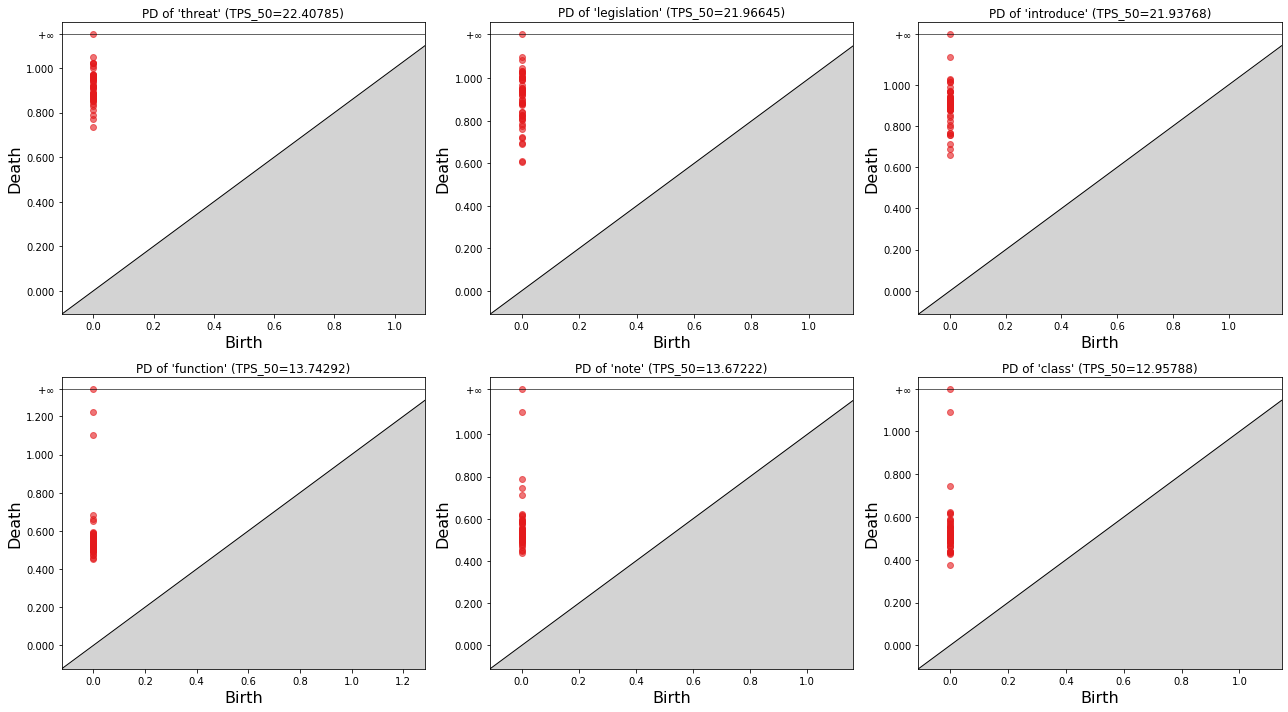

<IPython.core.display.Javascript object>

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6 * 3, 5 * 2))
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        if i == 0:
            tps_idx = j
        else:
            tps_idx = num_semeval_words - 3 + j
        word = semeval_target_words_in_vocab_sorted[tps_idx]
        word_tps = tps_scores_sorted[tps_idx]

        plot_persistence_diagram(tps_pds_sorted[tps_idx], axes=ax)
        ax.set_title(f"PD of '{word}' (TPS_{tps_neighbourhood_size}={word_tps:.5f})")
plt.tight_layout()
plt.show()

In [9]:
def pd_to_matrix(pd: np.ndarray, target_dim: int, include_inf: bool) -> np.ndarray:
    """
    TODO: Docs
    """
    result_mat = []
    for dim, (birth, death) in pd:
        if dim != target_dim or (not include_inf and death == np.inf):
            continue
        result_mat.append([birth, death])
    return np.array(result_mat)

<IPython.core.display.Javascript object>

In [10]:
def tps_pds_to_matrix(tps_pds: np.array, include_inf: bool = False) -> np.array:
    """
    TODO: Docs
    """
    result_mat = []
    for tps_pd in tps_pds:
        pd_mat = pd_to_matrix(pd=tps_pd, include_inf=include_inf, target_dim=0)
        result_mat.append(pd_mat)
    return np.array(result_mat)

<IPython.core.display.Javascript object>

# Clustering of TPS PDs

In [11]:
def pairwise_distances_pds(
    persistence_diagrams: np.ndarray,
    metric: Callable[[np.ndarray, np.ndarray], float],
    **kwargs: dict
) -> np.array:
    """
    TODO: Docs
    """
    n = len(persistence_diagrams)
    pairwise_dists = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(n):
            pairwise_dists[i, j] = metric(
                persistence_diagrams[i], persistence_diagrams[j], **kwargs
            )
    np.fill_diagonal(pairwise_dists, 0)

    return pairwise_dists

<IPython.core.display.Javascript object>

In [12]:
tps_pds_data = tps_pds_to_matrix(tps_pds_sorted)
tps_pds_data_with_inf = tps_pds_to_matrix(tps_pds_sorted, include_inf=True)
tps_pds_data_pairwise_dists_euclidean = pairwise_distances(
    tps_pds_data[:, :, 1], metric="euclidean"
)
tps_pds_data_pairwise_dists_bottle = pairwise_distances_pds(
    tps_pds_data, metric=bottleneck_distance
)
tps_pds_data_pairwise_dists_wasser = pairwise_distances_pds(
    tps_pds_data, metric=wasserstein_distance
)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [13]:
for dist_metric_name, pairwise_dists in [
    ("Euclidean", tps_pds_data_pairwise_dists_euclidean),
    ("Bottleneck", tps_pds_data_pairwise_dists_bottle),
    ("Wasserstein", tps_pds_data_pairwise_dists_wasser),
]:
    tps_pds_data_2d_mds = MDS(
        n_components=2, dissimilarity="precomputed", random_state=rng_seed
    ).fit_transform(pairwise_dists)
    tps_pds_data_2d_umap = UMAP(
        n_components=2, n_neighbors=5, metric="precomputed", random_state=rng_seed
    ).fit_transform(pairwise_dists)
    tps_pds_data_pred_labels = SpectralClustering(
        n_clusters=2, affinity="precomputed", random_state=rng_seed
    ).fit_predict(pairwise_dists)
    for embedding_name, embedding in [
        ("MDS", tps_pds_data_2d_mds),
        ("UMAP", tps_pds_data_2d_umap),
    ]:
        fig = px.scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            color=tps_scores_sorted,
            # symbol=[
            #    "circle" if label == 0 else "cross"
            #    for label in tps_pds_data_pred_labels
            # ],
            hover_data={"word": semeval_target_words_in_vocab_sorted},
            labels={
                "x": f"{embedding_name}1",
                "y": f"{embedding_name}2",
                "color": "TPS_50",
            },
            title=f"{dist_metric_name} distance with {embedding_name}",
        )
        fig.show()

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



<IPython.core.display.Javascript object>

# Clustering of cyclo-octane GAD PDs

In [14]:
# Load cyclo-octane data
cyclo_octane_data = pd.read_csv(
    join(topological_data_analysis_custom_data_dir, "cyclo-octane.csv"), header=None
).values
cyclo_octane_data.shape

(6040, 24)

<IPython.core.display.Javascript object>

In [15]:
gad_instance = GeometricAnomalyDetection(cyclo_octane_data)
gad_result = gad_instance.compute(
    word_ints=None,
    manifold_dimension=2,
    annulus_inner_radius=0.25,
    annulus_outer_radius=0.4,
    tqdm_enabled=True,
    return_annlus_persistence_diagrams=True,
)
annulus_pds = gad_result["annulus_pds"]

  0%|          | 0/6040 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [16]:
# Create vector with point colors
point_colors = np.empty(len(cyclo_octane_data), dtype=object)
for i in range(len(cyclo_octane_data)):
    for key in gad_result.keys():
        if key == "annulus_pds":
            continue
        if i in gad_result[key]:
            point_colors[i] = key

<IPython.core.display.Javascript object>

In [17]:
# gad_pds_data_pairwise_dists_euclidean = pairwise_distances(
#    annulus_pds[:, :, 1], metric="euclidean"
# )
compute_pd_pairwise_dists = False
if compute_pd_pairwise_dists:
    gad_pds_data_pairwise_dists_bottle = pairwise_distances_pds(
        annulus_pds, metric=bottleneck_distance
    )
    gad_pds_data_pairwise_dists_wasser = pairwise_distances_pds(
        annulus_pds, metric=wasserstein_distance
    )

    # Save
    np.save(
        join(
            topological_data_analysis_data_dir, "gad_pds_data_pairwise_dists_bottle.npy"
        ),
        gad_pds_data_pairwise_dists_bottle,
    )
    np.save(
        join(
            topological_data_analysis_data_dir, "gad_pds_data_pairwise_dists_wasser.npy"
        ),
        gad_pds_data_pairwise_dists_wasser,
    )
else:
    gad_pds_data_pairwise_dists_bottle = np.load(
        join(
            topological_data_analysis_data_dir, "gad_pds_data_pairwise_dists_bottle.npy"
        )
    )
    gad_pds_data_pairwise_dists_wasser = np.load(
        join(
            topological_data_analysis_data_dir, "gad_pds_data_pairwise_dists_wasser.npy"
        )
    )

<IPython.core.display.Javascript object>

In [18]:
# Ensure bottleneck distance is symmetric
gad_pds_data_pairwise_dists_bottle_sym = (
    gad_pds_data_pairwise_dists_bottle + gad_pds_data_pairwise_dists_bottle.T
) / 2

<IPython.core.display.Javascript object>

In [19]:
for dist_metric_name, pairwise_dists in [
    # ("Euclidean", gad_pds_data_pairwise_dists_bottle),
    ("Bottleneck", gad_pds_data_pairwise_dists_bottle_sym),
    ("Wasserstein", gad_pds_data_pairwise_dists_wasser),
]:
    print("UMAP...")
    pds_data_3d_umap = UMAP(
        n_components=2, n_neighbors=15, metric="precomputed", random_state=rng_seed
    ).fit_transform(pairwise_dists)
    print("Done!")
    print("Isomap...")
    pds_data_3d_isomap = Isomap(n_components=2, metric="precomputed").fit_transform(
        pairwise_dists
    )
    print("Done!")
    # print("AgglomerativeClustering...")
    # pds_data_pred_labels = AgglomerativeClustering(
    #    n_clusters=3, affinity="precomputed", linkage="average"
    # ).fit_predict(pairwise_dists)
    # print("Done!")
    for embedding_name, embedding in [
        ("UMAP", pds_data_3d_umap),
        ("Isomap", pds_data_3d_isomap),
    ]:
        fig = px.scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            # z=embedding[:, 2],
            color=point_colors,
            # symbol=[
            #    {"P_bnd": "square", "P_int": "cross", "P_man": "circle"}[label]
            #    for label in point_colors
            # ],
            # hover_data={"word": semeval_target_words_in_vocab_sorted},
            labels={
                "x": f"{embedding_name}1",
                "y": f"{embedding_name}2",
                # "z": f"{embedding_name}3",
                "color": "Category",
            },
            title=f"{dist_metric_name} distance with {embedding_name}",
        )
        fig.show()

UMAP...


/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



Done!
Isomap...
Done!


UMAP...


/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



Done!
Isomap...
Done!


<IPython.core.display.Javascript object>